In [1]:
import os
import nibabel as nib
import numpy as np
import skimage
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import cv2, pickle

In [2]:
# Prototype with one subject segmentation first
print(os.getcwd())
image_path = r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\imagesTr'
tumor_path = r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr'

# Organ segmentation files obtained from TotalSegmentator v1.5.7
# Results are generated from the run_total_segmentator.py script
label_organs_path = r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_segmentation\Task07_Pancreas\imagesTr'

# List all the files in the image path and label path, exclude files that start with ._ 
image_list = [f for f in os.listdir(image_path) if not f.startswith('._') and  'nii.gz' in f]
tumor_label_value = 2
number_of_organs = 104 
# Sort the list
image_list.sort()
print(len(image_list))

c:\Users\ADMIN\Desktop\Workspace\Code\3D-MIR-main\Code\Image-Processing-and-Quantification
281


In [7]:
import os
import pickle
import numpy as np
import SimpleITK as sitk

image_id_dict = {}
for image_name in image_list:
    label_organ_file = os.path.join(label_organs_path, image_name)
    label_organ = sitk.ReadImage(label_organ_file)
    img_emb_list = []

    # Get 3D matrix from the image
    label_organ_data = sitk.GetArrayFromImage(label_organ)

    for i in range(label_organ_data.shape[0]):
        label_slice = label_organ_data[i, :, :]
        # For label slice, create a dictionary where the key is the pixel value and the value is the number of pixels different from 0
        label_dict = dict(zip(*np.unique(label_slice, return_counts=True)))
        label_vector = np.zeros(104, dtype=int)
        for key, value in label_dict.items():
            if key > 0 and key - 1 < len(label_vector):
                label_vector[key - 1] = value

        img_emb_list.append(label_vector)

    # concatenate the vectors into a matrix
    full_emb = np.stack(img_emb_list, axis=0)
    image_id_dict[image_name] = full_emb.copy()

output_file = r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_2D_per_organ.pkl'
os.makedirs(os.path.dirname(output_file), exist_ok=True)

with open(output_file, "wb") as f:
    pickle.dump(image_id_dict, f)
print("Saved file: ", output_file)


Saved file:  C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_2D_per_organ.pkl


In [8]:
output_file = r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_2D_per_organ.pkl'
# Load pickle file
with open(output_file, "rb") as f:
    data_dict = pickle.load(f)
data_dict.keys()

dict_keys(['pancreas_001.nii.gz', 'pancreas_004.nii.gz', 'pancreas_005.nii.gz', 'pancreas_006.nii.gz', 'pancreas_010.nii.gz', 'pancreas_012.nii.gz', 'pancreas_015.nii.gz', 'pancreas_016.nii.gz', 'pancreas_018.nii.gz', 'pancreas_019.nii.gz', 'pancreas_021.nii.gz', 'pancreas_024.nii.gz', 'pancreas_025.nii.gz', 'pancreas_028.nii.gz', 'pancreas_029.nii.gz', 'pancreas_032.nii.gz', 'pancreas_035.nii.gz', 'pancreas_037.nii.gz', 'pancreas_040.nii.gz', 'pancreas_041.nii.gz', 'pancreas_042.nii.gz', 'pancreas_043.nii.gz', 'pancreas_045.nii.gz', 'pancreas_046.nii.gz', 'pancreas_048.nii.gz', 'pancreas_049.nii.gz', 'pancreas_050.nii.gz', 'pancreas_051.nii.gz', 'pancreas_052.nii.gz', 'pancreas_055.nii.gz', 'pancreas_056.nii.gz', 'pancreas_058.nii.gz', 'pancreas_061.nii.gz', 'pancreas_064.nii.gz', 'pancreas_066.nii.gz', 'pancreas_067.nii.gz', 'pancreas_069.nii.gz', 'pancreas_070.nii.gz', 'pancreas_071.nii.gz', 'pancreas_074.nii.gz', 'pancreas_075.nii.gz', 'pancreas_077.nii.gz', 'pancreas_078.nii.gz', 

In [10]:
import tqdm

# Create a dataframe to store the metrics per file and 2D image
df2d = pd.DataFrame(columns=['filename', 'slice', 'cancer_stage', 'tumor_area'] )
df3d = pd.DataFrame(columns=['filename','cancer_stage'])

# #iterate through the list of files image_list and label_list
# for image_name, label_name in tqdm.tqdm(zip(image_list, label_list)):
(stats_list_2d, stats_list_3d) = ([], [])
for image_name in image_list: 
#for image_name in tqdm.tqdm(image_list):
    print(image_name)

    (image_file, tumor_file, organs_file) = (os.path.join(image_path, image_name), os.path.join(tumor_path, image_name), os.path.join(label_organs_path, image_name))
    (image, tumor, organs) = (sitk.ReadImage(image_file), sitk.ReadImage(tumor_file), sitk.ReadImage(organs_file))

    # Cast tumor to int8 using CastImageFilter to uint8
    castFilter = sitk.CastImageFilter()
    castFilter.SetOutputPixelType(sitk.sitkUInt8)
    tumor = castFilter.Execute(tumor)

    (image_data, tumor_data, organs_data) = (sitk.GetArrayFromImage(image), sitk.GetArrayFromImage(tumor), sitk.GetArrayFromImage(organs))
    spacing = image.GetSpacing()

    # For tumor image make zero voxels except for tumor label, pancreas seems the exception from other msd cohorts
    tumor_data[tumor_data != tumor_label_value] = 0
    tumor_data[tumor_data == tumor_label_value] = 1

    #Get pixel type for organs
    pixel_type = tumor.GetPixelIDTypeAsString()
    tumor = sitk.GetImageFromArray(tumor_data)

    cc = sitk.ConnectedComponent(tumor)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(cc, tumor)
    print(tumor_file, stats.GetNumberOfLabels())
    # Get array of connected component numbers
    cc_tumor_array = sitk.GetArrayFromImage(cc)

    # Creates dictionary where key is tuple consisting of subject ID and label number
    #tumor_size_list = []
    for l in stats.GetLabels():
        # Ignore if number of voxels is less than 6

        # Remove spurius or flat objects objects 
        if stats.GetNumberOfPixels(l) < 3 or stats.GetBoundingBox(l)[-1] == 1:
            cc_tumor_array[cc_tumor_array == l] = 0
            continue

        # Count number of voxels in this connected component
        voxel_count = np.sum(cc_tumor_array == l)
        #Initialize dictionary containing different metrics
        cc_dictionary = {}
        cc_dictionary['image_name'] = image_name
        cc_dictionary['PhysicalSize_cm3'] = stats.GetPhysicalSize(l) * spacing[0] * spacing[1] * spacing[2] / 1000
        cc_dictionary['NumberOfVoxels'] = stats.GetNumberOfPixels(l)
        cc_dictionary['Roundness'] = stats.GetRoundness(l)
        cc_dictionary['Elongation'] = stats.GetElongation(l)
        cc_dictionary['Flatness'] = stats.GetFlatness(l)
        cc_dictionary['EquivalentSphericalRadius_cm'] = stats.GetEquivalentSphericalRadius(l)/10
        cc_dictionary['EquivalentSphericalPerimeter_cm'] = stats.GetEquivalentSphericalPerimeter(l)/10
        cc_dictionary['EquivalentEllipsoidDiameter'] = stats.GetEquivalentEllipsoidDiameter(l)
        cc_dictionary['major_axis_length_cm'] = max(stats.GetEquivalentEllipsoidDiameter(l)) / 10
        cc_dictionary['centroid'] = stats.GetCentroid(l)
        cc_dictionary['bounding_box'] = stats.GetBoundingBox(l)
        cc_dictionary['spacing']= spacing

        # Get the number of voxels in the tumor that are in the organ
        tumor_bbox = stats.GetBoundingBox(l)
        # Get voxels only in the tumor bounding box
        (x0,y0,z0,x1,y1,z1)= tumor_bbox
        # Add the width, height and depth to the x0, y0, z0
        (x1,y1,z1) = (x1+x0, y1+y0, z1+z0)
        # Coordinate systems ITK - Numpy are different:
        (organ_bbox_array, tumor_bbox_array)  = (organs_data[z0:z1, y0:y1, x0:x1], cc_tumor_array[z0:z1, y0:y1, x0:x1])

        # Quantifies tumor in each organ
        for i in range(number_of_organs+1):
            cc_dictionary['organ_'+str(i)+'_voxel_count'] = 0
            # organ_voxel_count = np.sum(np.logical_and(cc_tumor_array == l, organs_data == i))

        (voxel_values, voxel_counts) = np.unique(organ_bbox_array[tumor_bbox_array == l], return_counts=True)
        for (v,c) in zip(voxel_values, voxel_counts):
            cc_dictionary['organ_'+str(v)+'_voxel_count'] = c
        stats_list_3d.append(cc_dictionary.copy())

    # 2D Report -- Iterate through the slices
    for i in range(organs_data.shape[0]):
        tumor_slice = cc_tumor_array[i,:,:]
        organs_slice = organs_data[i,:,:]

        if not np.any(tumor_slice):
            continue

        number_of_tumors = 0
        # OpenCV returns number of objects + 1
        number_of_tumors = cv2.connectedComponents(tumor_slice.astype('uint8'),connectivity=8)[0] - 1

        # Calculate area of the tumors
        tumor_area_cm2 = np.sum(tumor_slice == 1) * spacing[0] * spacing[1] / 100

        # Localize where in the organs the tumor is
        organ_voxel_count_2d_dict = {}
        organ_voxel_count_2d_dict['filename']= image_name
        organ_voxel_count_2d_dict['slice']= i
        organ_voxel_count_2d_dict['number_of_tumors']= number_of_tumors
        organ_voxel_count_2d_dict['tumor_area_cm2']= tumor_area_cm2
        organ_voxel_count_2d_dict['spacing'] = spacing
        for i in range(number_of_organs+1):
            organ_voxel_count = np.sum(np.logical_and(tumor_slice > 0, organs_slice == i))
            organ_voxel_count_2d_dict['organ_'+str(i)+'_voxel_count'] = organ_voxel_count

        stats_list_2d.append(organ_voxel_count_2d_dict.copy())

df_tumor_report_2d = pd.DataFrame(stats_list_2d)
df_tumor_report_3d = pd.DataFrame(stats_list_3d)

df_tumor_report_3d.to_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_3D_tumor_per_organ.csv', index=False)
df_tumor_report_2d.to_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_2D_tumor_per_organ.csv', index=False)


pancreas_001.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_001.nii.gz 1
pancreas_004.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_004.nii.gz 1
pancreas_005.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_005.nii.gz 1
pancreas_006.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_006.nii.gz 1
pancreas_010.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_010.nii.gz 1
pancreas_012.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_012.nii.gz 1
pancreas_015.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_015.nii.gz 1
pancreas_016.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\labelsTr\pancreas_016.nii.gz 1
pancreas_018.nii.gz
C:\Users\ADMIN\Desktop\Workspace\Code\data\msd\Task07_Pancreas\label

In [11]:
# Read the data frames
df3d = pd.read_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_3D_tumor_per_organ.csv')
df2d = pd.read_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_2D_tumor_per_organ.csv')

In [12]:
image_name_list_with_tumor = df3d.image_name.unique().tolist()
image_name_list_all_subjects = [f for f in data_dict.keys()]

subject_list = []
# Group by image name and iterate through the groups
for name, group in df3d.groupby('image_name'):
    subject_dict = {}
    # Number of tumors
    number_tumors_group = len(group)    
    max_tumor_size_group = max(group.major_axis_length_cm)
    cancer_stage = -1 # No Cancer
    # Get cancer stage
    # For details see: https://www.cancerresearchuk.org/about-cancer/pancreatic-cancer/stages-types-grades/tnm-staging
    # A very rough and oversimplified approximation using only tumor size, consider the following hypothetical rule:
    # Tumor size ≤ 2 cm: Approximate as Stage I (T1)
    # Tumor size > 2 cm and ≤ 4 cm: Approximate as Stage IIa (T2)
    # Tumor size > 4 cm and ≤ 6 cm: Approximate as Stage IIb (T3)
    # T3 means the cancer is bigger than 4cm but is still within the pancreas. (T4)
    # Please note that T staging also considers depth of invasion into the pancreas wall and surrounding structures, not just diameter size.
    # Here we will use fictional staging for 1, 2, 3

    # Stage 1
    if max_tumor_size_group < 2:
        cancer_stage = 1
    # Stage 2
    elif  max_tumor_size_group >= 2 and max_tumor_size_group < 4:
        cancer_stage = 2
    # Stage 3
    elif  max_tumor_size_group >= 4 and max_tumor_size_group < 6:
        cancer_stage = 3
    else:
    # Stage 4
        cancer_stage = 4


    subject_dict['name'] = name
    subject_dict['max_tumor_size'] = max_tumor_size_group
    subject_dict['number_tumors'] = number_tumors_group
    subject_dict['cancer_stage'] = cancer_stage
    
    subject_list.append(subject_dict.copy())

df_subject = pd.DataFrame(subject_list)
df_subject.to_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_3D_subject.csv', index=False)

<Axes: >

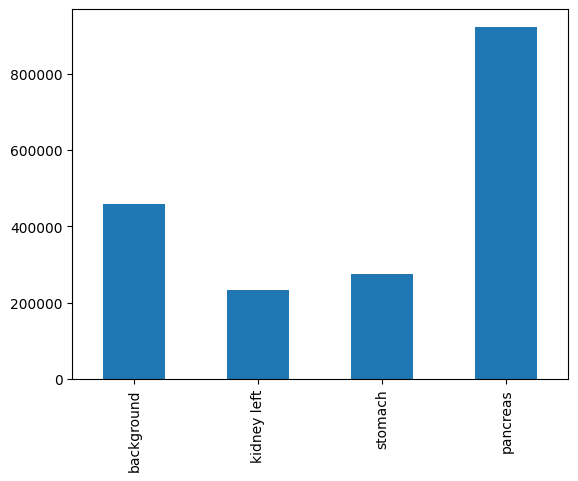

In [13]:
# Distribution of tumor vs organ number where values are non-zero
df3d_organ = df3d.loc[:, df3d.columns.str.startswith('organ')]
# Remove columns with all zeros
df3d_organ = df3d_organ.loc[:, (df3d_organ != 0).any(axis=0)]

# # Remove columns with less than 400 voxel counts
df3d_organ = df3d_organ.loc[:, df3d_organ.sum() > 40000]

# print(df3d_organ.sum())

df3d_organ.sum().plot(kind='bar')
#10	pancreas

# Rename columns as follows: 
# organ 0 is backbround
# organ 3 is kidney_left	
# organ 6	stomach
# organ 10	pancreas
df3d_organ.columns = ['background', 'kidney left', 'stomach', 'pancreas']
df3d_organ.sum().plot(kind='bar')

# Normalize the number of voxels as cm3
# df3d_organ = df3d_organ.div(df3d_organ.sum(axis=1), axis=0)

# Plot histogram of number of voxels per organ normalized by total number of voxels
#df3d_organ.sum().plot(kind='bar', title='Percentage of voxel tumor count per organ')






name              pancreas_415.nii.gz
max_tumor_size              13.961877
number_tumors                       1
cancer_stage                        4
Name: 276, dtype: object

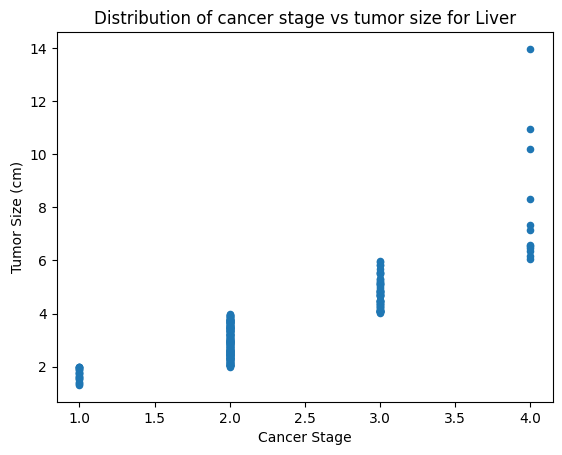

In [14]:
# Plot distribution of cancer stage for integer values vs tumor size
df_subject.plot.scatter(x='cancer_stage', y='max_tumor_size')

# Title
plt.title('Distribution of cancer stage vs tumor size for Liver')

# X label
plt.xlabel('Cancer Stage')

# Y label
plt.ylabel('Tumor Size (cm)')

# show file with maximum tumor size
df_subject.loc[df_subject['max_tumor_size'].idxmax()]


Text(0.5, 0, 'Tumor length (less than 20cm) per subject')

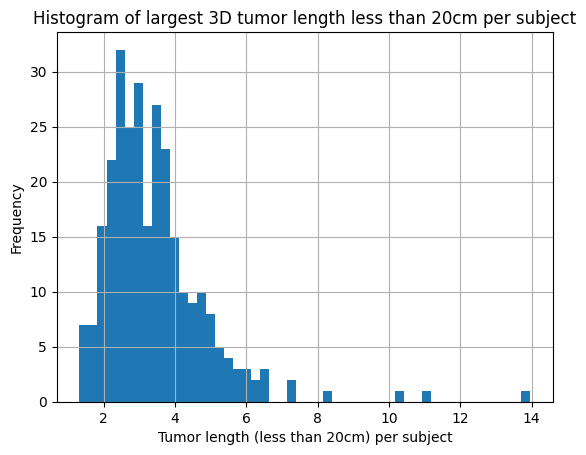

In [15]:
df3d.columns
#Plot largest_tumor_length_cm histogram, where tumor_length_cm is less than 20cm and gretar than zero, using 100 bins
df3d[ (df3d.major_axis_length_cm > 0) &  (df3d.major_axis_length_cm < 20)].major_axis_length_cm.hist(bins=50)
# Title
plt.title("Histogram of largest 3D tumor length less than 20cm per subject")
# Y label
plt.ylabel("Frequency")
# X label
plt.xlabel("Tumor length (less than 20cm) per subject")

Text(0.5, 1.0, 'Tumor area vs number of tumors')

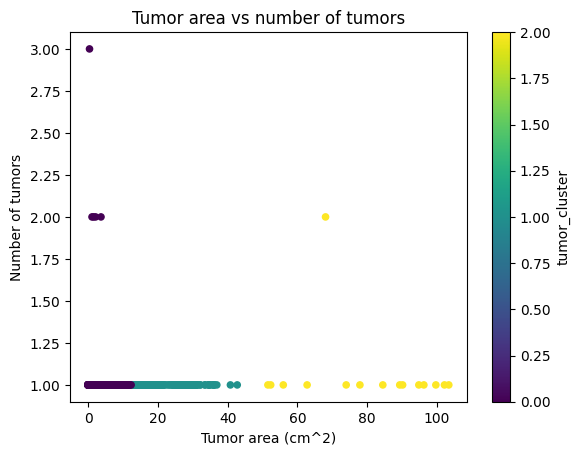

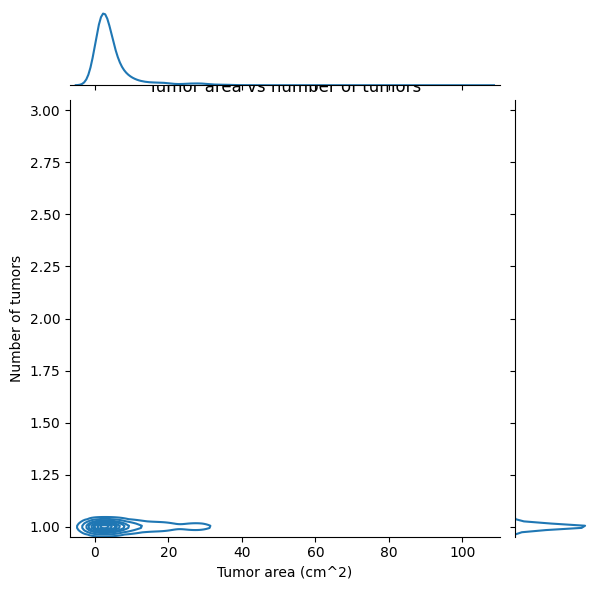

In [16]:
# cluster the tumor_area and number_of_tumors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df2d[['tumor_area_cm2', 'number_of_tumors']])
df2d['tumor_cluster'] = kmeans.predict(df2d[['tumor_area_cm2', 'number_of_tumors']])
df2d.plot.scatter(x='tumor_area_cm2', y='number_of_tumors', c='tumor_cluster', colormap='viridis')

# Axis title
plt.xlabel('Tumor area (cm^2)')
plt.ylabel('Number of tumors')
plt.title('Tumor area vs number of tumors')

# # show density plot of tumor_area and number_of_tumors
import seaborn as sns
sns.jointplot(x='tumor_area_cm2', y='number_of_tumors', data=df2d, kind='kde')

# Axis title
plt.xlabel('Tumor area (cm^2)')
plt.ylabel('Number of tumors')
plt.title('Tumor area vs number of tumors')

In [17]:
df2d['tumor_cluster'].value_counts()

# Get mean value of tumor_area and number_of_tumors for each cluster
df2d.groupby('tumor_cluster')[['tumor_area_cm2', 'number_of_tumors']].mean()

,tumor_area_cm2,number_of_tumors
tumor_cluster,,
0,3.363164,1.002588
1,21.888680,1.000000
2,80.193800,1.066667


Index(['name', 'max_tumor_size', 'number_tumors', 'cancer_stage'], dtype='object')


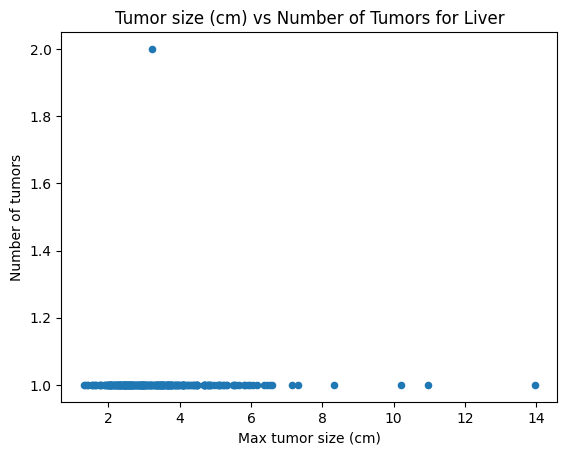

In [18]:
df_subject = pd.read_csv(r'C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\msd_pancreas_metrics_3D_subject.csv')
print(df_subject.columns)
# Plot scatter plot of tumor_area vs number_of_tumors where tumor_flag is 1
df_subject.plot.scatter(x='max_tumor_size', y='number_tumors')
# Axis title
plt.xlabel('Max tumor size (cm)')
plt.ylabel('Number of tumors')
plt.title('Tumor size (cm) vs Number of Tumors for Liver')
plt.ticklabel_format(style='plain')